In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# Enable GPU growth to prevent TensorFlow from allocating all memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs detected and configured: {[gpu.name for gpu in gpus]}")
else:
    print("No GPU detected. Check CUDA and cuDNN installations if GPU is available.")

No GPU detected. Check CUDA and cuDNN installations if GPU is available.


In [3]:
BASE_DIR = 'D:/Dataset'
Captions_Dir = 'D:/Dataset/Caption'
WORKING_DIR = 'D:/Dataset/WORKING'

In [4]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# Feature extraction using VGG16 with GPU support


In [6]:
with open(os.path.join(WORKING_DIR, 'featuresVGG16.pkl'), 'rb') as f:
    featuresVGG16 = pickle.load(f)

In [7]:
featuresVGG16["1000268201"].shape

(1, 4096)

In [8]:
with open('D:/Dataset/Caption/New_Caption.txt', 'r', encoding='utf-8', errors='ignore') as f:
    next(f)
    captions_doc = f.read()

In [9]:
captions_doc.split('\n')[0]

'1000092795,झबरे बालों वाले दो युवा आँगन में घूमते समय अपने हाथों को देख रहे हैं।'

In [10]:
mapping = {}
idx=0
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    caption = " ".join(caption)
    if idx<=10:
        print(image_id,caption)
        idx+=1
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/158915 [00:00<?, ?it/s]

1000092795,झबरे बालों वाले दो युवा आँगन में घूमते समय अपने हाथों को देख रहे हैं।
1000092795,दो युवा, श्वेत नर बाहर कई झाड़ियों के पास हैं।
1000092795,हरी शर्ट पहने दो आदमी एक आँगन में खड़े हैं।
1000092795,नीली शर्ट पहने एक आदमी बगीचे में खड़ा है।
1000092795,दो दोस्त एक साथ समय बिताकर आनंद लेते हैं।
10002456,सख्त टोपी पहने कई आदमी एक विशाल चरखी प्रणाली का संचालन कर रहे हैं।
10002456,श्रमिक ऊपर से नीचे उपकरण के एक टुकड़े को देखते हैं।
10002456,दो आदमी सख्त टोपी पहने हुए एक मशीन पर काम कर रहे हैं।
10002456,एक ऊंची इमारत के शीर्ष पर चार आदमी।
10002456,एक बड़े रिग पर तीन आदमी।
1000268201,गुलाबी पोशाक में एक बच्चा प्रवेश मार्ग में सीढ़ियों पर चढ़ रहा है।


In [11]:
def clean(mapping):
    idx=0;
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('एक', "")
            caption = caption.replace('।', "")
            caption = caption.replace(',', " ")
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# Path to your captions file
caption_file_path = 'D:/Dataset/Caption/New_Caption.txt'

# Initialize an empty dictionary to store the mapping
mapping = {}

# Read the file and create the mapping
with open(caption_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        # Split the line into image ID and caption
        parts = line.strip().split(',', 1)  # Split only at the first comma
        if len(parts) == 2:
            image_id, caption = parts
            # If the image_id is already in the mapping, append the caption to the list
            if image_id in mapping:
                mapping[image_id].append(caption)
            else:
                # If the image_id is not in the mapping, create a new list for the captions
                mapping[image_id] = [caption]

# Example: Access captions for a specific image ID
image_id_to_check = '1000092795'
if image_id_to_check in mapping:
    print(f"Captions for image ID {image_id_to_check}:")
    for caption in mapping[image_id_to_check]:
        print(f" - {caption}")
else:
    print(f"Image ID {image_id_to_check} not found in the mapping.")



Captions for image ID 1000092795:
 - झबरे बालों वाले दो युवा आँगन में घूमते समय अपने हाथों को देख रहे हैं।
 - दो युवा, श्वेत नर बाहर कई झाड़ियों के पास हैं।
 - हरी शर्ट पहने दो आदमी एक आँगन में खड़े हैं।
 - नीली शर्ट पहने एक आदमी बगीचे में खड़ा है।
 - दो दोस्त एक साथ समय बिताकर आनंद लेते हैं।


In [13]:
mapping['1000268201']

['गुलाबी पोशाक में एक बच्चा प्रवेश मार्ग में सीढ़ियों पर चढ़ रहा है।',
 'गुलाबी पोशाक में एक छोटी लड़की लकड़ी के केबिन में जा रही है।',
 'एक छोटी लड़की अपने खेल के घर की सीढ़ियाँ चढ़ रही है।',
 'एक छोटी लड़की लकड़ी के खेल के घर में चढ़ रही है',
 'एक लड़की लकड़ी की इमारत में जा रही है।']

In [14]:
clean(mapping)

In [15]:
mapping['1000268201']

['startseq गुलाबी पोशाक में बच्चा प्रवेश मार्ग में सीढ़ियों पर चढ़ रहा है endseq',
 'startseq गुलाबी पोशाक में छोटी लड़की लकड़ी के केबिन में जा रही है endseq',
 'startseq छोटी लड़की अपने खेल के घर की सीढ़ियाँ चढ़ रही है endseq',
 'startseq छोटी लड़की लकड़ी के खेल के घर में चढ़ रही है endseq',
 'startseq लड़की लकड़ी की इमारत में जा रही है endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
all_captions[:5]

['startseq झबरे बालों वाले दो युवा आँगन में घूमते समय अपने हाथों को देख रहे हैं endseq',
 'startseq दो युवा श्वेत नर बाहर कई झाड़ियों के पास हैं endseq',
 'startseq हरी शर्ट पहने दो आदमी आँगन में खड़े हैं endseq',
 'startseq नीली शर्ट पहने आदमी बगीचे में खड़ा है endseq',
 'startseq दो दोस्त साथ समय बिताकर आनंद लेते हैं endseq']

In [18]:
len(all_captions)

158915

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
#Saving tokenizer as pickle file
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))

In [21]:
#Loading tokenizer
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'rb') as f:
    tokenizer = pickle.load(f)

In [22]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

101

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size, epoch_limit=1):
    X1, X2, y = list(), list(), list()
    n = 0
    epoch_count = 0  # Track epochs completed
    while epoch_count < epoch_limit:
        for key in data_keys:
            n += 1
            if key not in mapping:
                continue
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    if key in features:
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
        epoch_count += 1  # Increment epoch count after one pass through `data_keys`




In [25]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [26]:
epochArr=[]
for i in range(25):
    epochArr.append(i);

In [27]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
def makeGraph(x,y):
    plt.plot(x, y)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [29]:
print(f"Total features extracted: {len(featuresVGG16)}")

Total features extracted: 31783


7151/7151 [==============================] - 1802s 252ms/step - loss: 2.5765


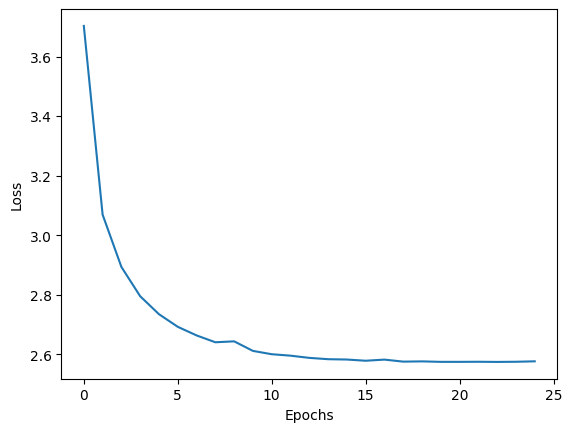

In [30]:
# train the model
epochs=25
batch_size = 4
steps = len(train) // batch_size
loss=[]
for i in range(epochs):
    
    generator = data_generator(train, mapping, featuresVGG16, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(model.history.history['loss'][0])

makeGraph(epochArr,loss)


In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu

In [34]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, featuresVGG16[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.485954
BLEU-2: 0.307205


In [ ]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))